In [28]:
import pandas as pd
import os
import numpy as np

In [32]:
sample_sheet = pd.read_csv("~/Desktop/gdc_sample_sheet.2025-05-24.tsv", sep = "\t")
sample_sheet['patient_id'] = sample_sheet['Case ID'].str.split(',', n=1).str[0]
sample_sheet

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Tissue Type,Tumor Descriptor,Specimen Type,Preservation Method,patient_id
0,4d8f5377-1b3f-42fc-b30d-56676e6fcff1,TCGA-HNSC.b24695ff-10a8-480f-885a-3da3356b3678...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,TCGA-CN-6024,TCGA-CN-6024-01A,Tumor,Primary,Solid Tissue,Unknown,TCGA-CN-6024
1,0dedce03-c368-4db8-837d-3d1cbfc07b44,TCGA-HNSC.a3a3e8ac-0a4d-471e-abaf-869184483285...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,TCGA-CQ-7068,TCGA-CQ-7068-01A,Tumor,Primary,Solid Tissue,Unknown,TCGA-CQ-7068
2,2b382e9d-3727-48bc-adad-7942c04e9ed7,TCGA-HNSC.f8be7bc9-dbbd-4cc7-93eb-066f3aa522db...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,TCGA-HD-7229,TCGA-HD-7229-01A,Tumor,Primary,Solid Tissue,Unknown,TCGA-HD-7229
3,e7952a90-ef15-43da-97f7-14d3bbfefcba,TCGA-HNSC.dc985e57-caef-4c8f-adc9-92d035701c3e...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,TCGA-BB-4227,TCGA-BB-4227-01A,Tumor,Primary,Solid Tissue,Unknown,TCGA-BB-4227
4,5a33ddaa-89bc-4062-9a52-be54702306d7,TCGA-HNSC.5d07e7cd-558a-41ac-b066-b4f234522a96...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,TCGA-CQ-A4C7,TCGA-CQ-A4C7-01A,Tumor,Primary,Solid Tissue,Unknown,TCGA-CQ-A4C7
...,...,...,...,...,...,...,...,...,...,...,...,...
510,6f31f6c3-7f63-48fc-bcb7-67168e2e76e5,TCGA-HNSC.a3e9465b-c53b-4aa4-b2ac-fe3fa9a76c47...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,TCGA-CX-7082,TCGA-CX-7082-01A,Tumor,Primary,Solid Tissue,Unknown,TCGA-CX-7082
511,eb8feb46-7023-425b-87f8-15bf86f48502,TCGA-HNSC.6ecd61db-f545-4831-a67c-dd6f3914b308...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,TCGA-CV-7103,TCGA-CV-7103-01A,Tumor,Primary,Solid Tissue,Unknown,TCGA-CV-7103
512,ba14e621-740b-4997-8d63-f6bce229e9bc,TCGA-HNSC.73309f6f-8b62-43a9-bae1-b2ba8fc98c64...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,TCGA-BA-A6DG,TCGA-BA-A6DG-01A,Tumor,Primary,Unknown,Unknown,TCGA-BA-A6DG
513,f07fbde1-362d-43a9-8203-68d3eb62c449,TCGA-HNSC.a42cb29c-9cc4-4d5c-a525-56f1d1c657ae...,Copy Number Variation,Gene Level Copy Number,TCGA-HNSC,TCGA-H7-A6C5,TCGA-H7-A6C5-01A,Tumor,Primary,Unknown,Unknown,TCGA-H7-A6C5


In [35]:
sample_info = pd.read_csv("~/Desktop/TCGA_mastercalls.abs_tables_JSedit.fixed.txt", sep = "\t")
sample_info['patient_id'] = (
    sample_info['array']
      .str.split('-')
      .str[:3]
      .str.join('-')
)
sample_info = sample_info[sample_info['patient_id'].isin(sample_sheet['patient_id'])]
sample_info

,array,sample,call status,purity,ploidy,Genome doublings,Coverage for 80% power,Cancer DNA fraction,Subclonal genome fraction,solution,patient_id
2837,TCGA-4P-AA8J-01,TCGA-4P-AA8J-01A-11D-A390-01,called,0.36,1.96,0.0,26.0,0.36,0.23,new,TCGA-4P-AA8J
2838,TCGA-BA-4074-01,TCGA-BA-4074-01A-01D-1432-01,called,0.61,1.79,0.0,12.0,0.58,0.06,new,TCGA-BA-4074
2839,TCGA-BA-4076-01,TCGA-BA-4076-01A-01D-1432-01,called,0.85,1.99,0.0,9.0,0.85,0.04,new,TCGA-BA-4076
2840,TCGA-BA-4078-01,TCGA-BA-4078-01A-01D-1432-01,called,0.86,1.76,0.0,8.0,0.85,0.02,new,TCGA-BA-4078
2841,TCGA-BA-5149-01,TCGA-BA-5149-01A-01D-1510-01,called,0.50,3.10,1.0,21.0,0.61,0.12,new,TCGA-BA-5149
...,...,...,...,...,...,...,...,...,...,...,...
10714,TCGA-DQ-7590-01,HNSC-TCGA-DQ-7590-Tumor-SM-2XW9S,maf_call,0.55,1.93,0.0,14.0,0.55,NaN,old,TCGA-DQ-7590
10715,TCGA-DQ-7594-01,HNSC-TCGA-DQ-7594-Tumor-SM-2XWA3,maf_call,0.49,1.90,0.0,16.0,0.48,NaN,old,TCGA-DQ-7594
10716,TCGA-DQ-7595-01,HNSC-TCGA-DQ-7595-Tumor-SM-2XW93,maf_call,0.59,1.90,0.0,13.0,0.57,NaN,old,TCGA-DQ-7595
10763,TCGA-HD-7917-01,HNSC-TCGA-HD-7917-Tumor-SM-2XW9E,maf_call,0.64,1.87,0.0,12.0,0.63,NaN,old,TCGA-HD-7917


In [48]:
base_dir = os.path.expanduser("~/Desktop/cnv/")

status_dict = {}

for patient in sample_sheet["patient_id"].unique():
    fn = (sample_sheet
        .loc[sample_sheet["patient_id"] == patient, "File Name"]
        .astype(str)
        .iloc[0]
    )
    df = pd.read_csv(os.path.join(base_dir, fn), sep="\t")
    df = df.dropna(subset=['copy_number'])
    df = df.drop_duplicates(subset='gene_name', keep='first')

    ploidy = sample_info.loc[sample_info["patient_id"] == patient, "ploidy"].iloc[0]

    df['cnv_status'] = df['copy_number'].dropna().apply(
        lambda x: 1 if np.log2((x+1e-6)/ploidy) >= 0.3
                  else (-1 if np.log2((x+1e-6)/ploidy) <= -0.3
                        else 0)
    )

    status_dict[patient] = df.set_index('gene_name')['cnv_status']

cnv_status_df = pd.DataFrame(status_dict)

cnv_status_df


,TCGA-CN-6024,TCGA-CQ-7068,TCGA-HD-7229,TCGA-BB-4227,TCGA-CQ-A4C7,TCGA-BA-6871,TCGA-BB-4223,TCGA-CX-7219,TCGA-CV-7410,TCGA-BA-5557,...,TCGA-D6-A6EQ,TCGA-P3-A5Q6,TCGA-CR-6484,TCGA-BA-A6DA,TCGA-BA-4075,TCGA-CX-7082,TCGA-CV-7103,TCGA-BA-A6DG,TCGA-H7-A6C5,TCGA-CR-7393
gene_name,,,,,,,,,,,,,,,,,,,,,
5S_rRNA,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
5_8S_rRNA,1.0,0.0,0.0,0.0,1.0,-1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0
7SK,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZEF1,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,...,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
ZZZ3,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,1.0,0.0,0.0
hsa-mir-1253,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,...,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0


(array([ 571.,  410.,  255.,   50.,   22.,   17.,   13.,   67.,  321.,
          89.,  640., 1041., 1081., 1880., 1422.,  962., 1680., 2266.,
        1943., 2350., 3512., 3566., 3103., 5938., 3538., 3502., 2588.,
        1789., 1493., 2785., 1414.,  896.,  412.,  495.,  509.,  442.,
          75.,  246.,  106.,   16.,  209.,  204.,  259.,  275.,  180.,
         427.,  452.,  337.,   87.,  189.]),
 array([-0.71679688, -0.68837289, -0.6599489 , -0.63152491, -0.60310092,
        -0.57467694, -0.54625295, -0.51782896, -0.48940497, -0.46098098,
        -0.432557  , -0.40413301, -0.37570902, -0.34728503, -0.31886105,
        -0.29043706, -0.26201307, -0.23358908, -0.20516509, -0.17674111,
        -0.14831712, -0.11989313, -0.09146914, -0.06304516, -0.03462117,
        -0.00619718,  0.02222681,  0.0506508 ,  0.07907478,  0.10749877,
         0.13592276,  0.16434675,  0.19277074,  0.22119472,  0.24961871,
         0.2780427 ,  0.30646669,  0.33489067,  0.36331466,  0.39173865,
         0.42016

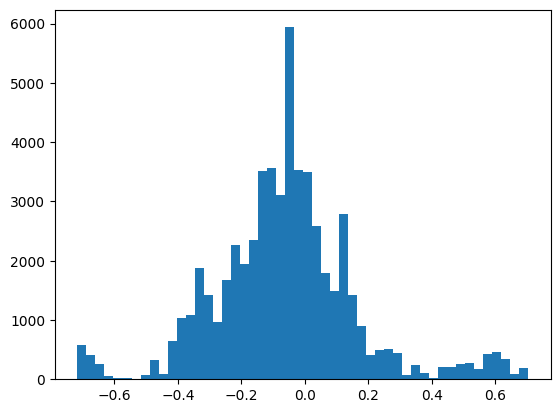

In [51]:
import matplotlib.pyplot as plt
plt.hist(cnv_status_df.mean(axis=1), bins=50)

In [52]:
counts = cnv_status_df.apply(lambda row: row.value_counts(), axis=1)
counts

,-1.0,0.0,1.0
gene_name,,,
5S_rRNA,18.0,422.0,75.0
5_8S_rRNA,18.0,356.0,122.0
7SK,56.0,410.0,49.0
A1BG,74.0,381.0,59.0
A1BG-AS1,74.0,381.0,59.0
...,...,...,...
ZZEF1,119.0,367.0,29.0
ZZZ3,86.0,409.0,19.0
hsa-mir-1253,118.0,368.0,29.0


In [53]:
na_frac = cnv_status_df.isna().mean(axis=1)
filtered_cnv_status = cnv_status_df[na_frac <= 0.2]

In [54]:
meta_data = pd.read_csv("~/Desktop/BNFO285_Projects/Data/processed/processed_metadata.txt", sep="\t")
patients_of_interest = meta_data["patient_id"]
filtered_cnv_status = filtered_cnv_status[list(set(filtered_cnv_status.columns).intersection(patients_of_interest))]
filtered_cnv_status

,TCGA-CN-A642,TCGA-UF-A7JH,TCGA-UF-A7JO,TCGA-CV-7180,TCGA-CV-6942,TCGA-H7-A6C5,TCGA-BA-A4IF,TCGA-F7-A61V,TCGA-CV-7253,TCGA-QK-A8Z8,...,TCGA-CV-5442,TCGA-CV-6441,TCGA-CV-7091,TCGA-HD-7753,TCGA-CV-6950,TCGA-BB-A6UO,TCGA-CR-6480,TCGA-DQ-5629,TCGA-CQ-5333,TCGA-CN-6019
gene_name,,,,,,,,,,,,,,,,,,,,,
5S_rRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0
5_8S_rRNA,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7SK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
A1BG,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZEF1,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,...,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0
ZZZ3,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
hsa-mir-1253,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,...,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0


In [40]:
gtf = (
    pd.read_csv(
        "~/Desktop/gencode.v38.annotation.gtf",
        sep="\t",
        comment="#",
        header=None,
        names=[
            "chrom","source","feature",
            "start","end","score","strand","frame","attribute"
        ],
    )
    .query("feature == 'gene'")
)

def _parse_attr(s):
    d = {}
    for field in s.split(";"):
        if not field.strip(): 
            continue
        key, val = field.strip().split(" ", 1)
        d[key] = val.strip('"')
    return d

attrs = gtf["attribute"].apply(_parse_attr)
gtf["gene_name"] = attrs.map(lambda d: d.get("gene_name"))
gtf["gene_type"] = attrs.map(lambda d: d.get("gene_type"))

coding = set(
    gtf
    .loc[gtf["gene_type"] == "protein_coding", "gene_name"]
    .dropna()
)

In [55]:
filtered_coding = filtered_cnv_status.loc[filtered_cnv_status.index.isin(coding)]
filtered_coding

,TCGA-CN-A642,TCGA-UF-A7JH,TCGA-UF-A7JO,TCGA-CV-7180,TCGA-CV-6942,TCGA-H7-A6C5,TCGA-BA-A4IF,TCGA-F7-A61V,TCGA-CV-7253,TCGA-QK-A8Z8,...,TCGA-CV-5442,TCGA-CV-6441,TCGA-CV-7091,TCGA-HD-7753,TCGA-CV-6950,TCGA-BB-A6UO,TCGA-CR-6480,TCGA-DQ-5629,TCGA-CQ-5333,TCGA-CN-6019
gene_name,,,,,,,,,,,,,,,,,,,,,
A1BG,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,...,-1.0,1.0,0.0,NaN,-1.0,0.0,0.0,0.0,0.0,-1.0
A2M,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.0,-1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
A2ML1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.0,-1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
A3GALT2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0
ZYG11B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0
ZYX,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [56]:
filtered_coding.to_csv("~/Desktop/BNFO285_Projects/Data/processed/filtered_cnv_status.tsv", index=True, sep = "\t")